# Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Camera Calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in cal_images:

    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


_, cameraMatrix, distCoeffs, _, _ = cv2.calibrateCamera(
    objpoints, imgpoints, cv2.imread(cal_images[0]).shape[1:], None, None);

## Create function to undistort images

In [3]:
def undistort_image(img):
    return cv2.undistort(img, cameraMatrix, distCoeffs, None, cameraMatrix);

## Print undistorted images

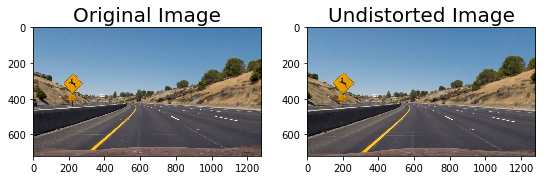

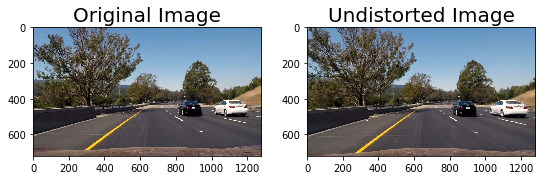

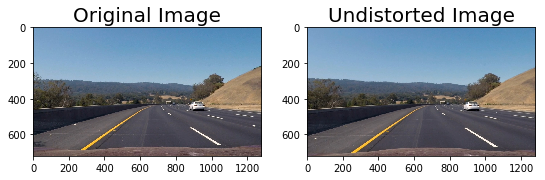

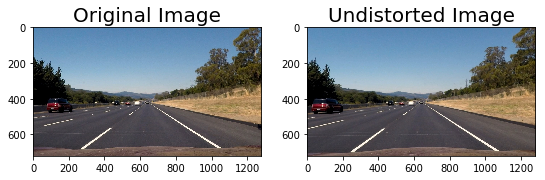

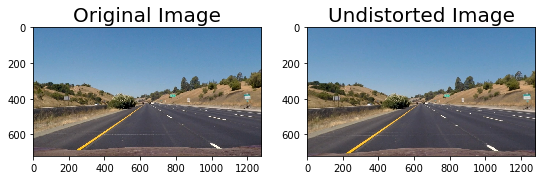

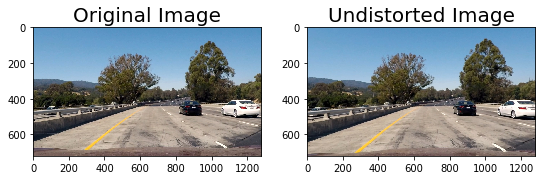

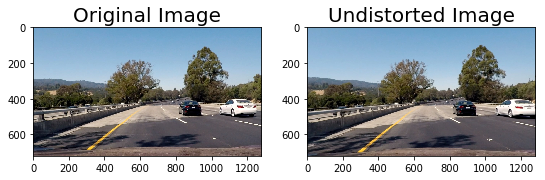

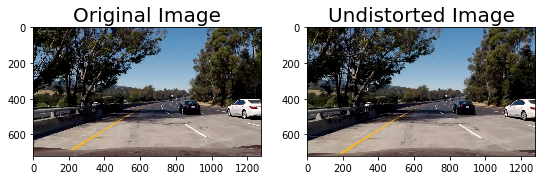

In [4]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

for img in images:
    undist = undistort_image(img)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=20)

# Perspective Transform

In [5]:
def transform_to_birds_eye_view(image):
    height, width, _ = image.shape
    
    src_points = np.array([[
        ((width/2)-50, (height/2)+90), # Top Left
        ((width/2)+50, (height/2)+90), # Top Right
        (200, height),                 # Bottom Left
        (width-200, height),           # Bottom Right

    ]], dtype=np.float32)
    
    dst_points = np.array([[
        ((width/4), 0),        # Top Left
        ((width/4)*3, 0),      # Top Right
        ((width/4), height),   # Bottom Left
        ((width/4)*3, height), # Bottom Right
    ]], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_points, dst_points)  
     
    img = np.copy(image)
    warped = cv2.warpPerspective(img, M, (width, height))
    return warped

## Print Birds eye images

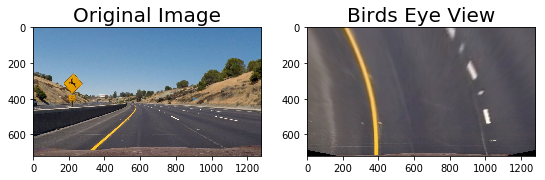

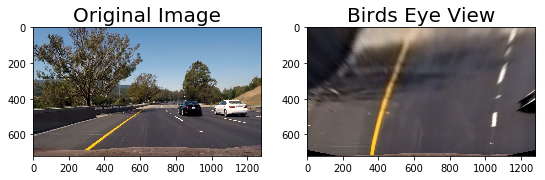

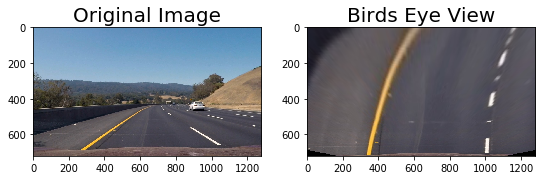

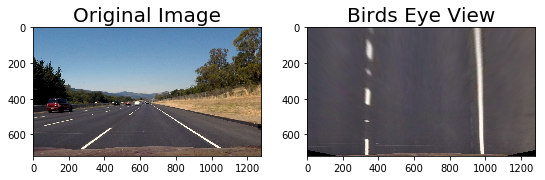

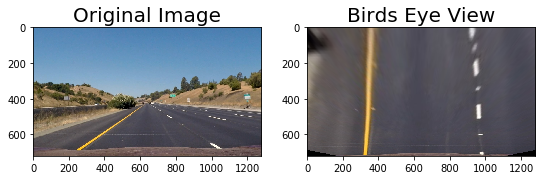

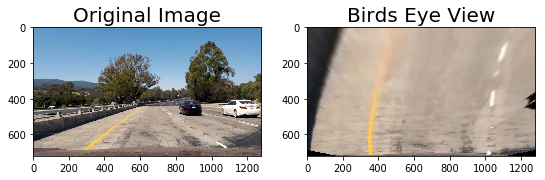

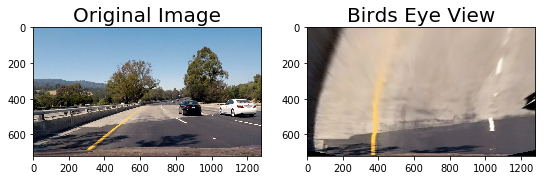

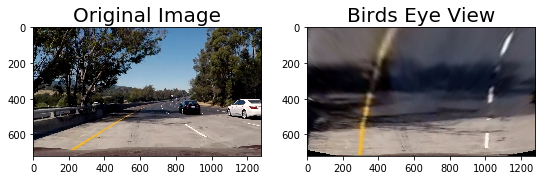

In [6]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

for img in images:
    undist = undistort_image(img)
    birds_eye = transform_to_birds_eye_view(undist)
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(cv2.cvtColor(birds_eye, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birds Eye View', fontsize=20)

# Thresholds 

In [7]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1 if orient=='x' else 0, 0 if orient=='x' else 1)
    # 3) Take the absolute value of the derivative or gradient
    sobelabs = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaledSobel = np.uint8(255*sobelabs / (np.max(sobelabs)))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaledSobel)
    binary_output[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude 
    sobelMag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobelScaled = np.uint8( 255*sobelMag / np.max(sobelMag) )
    
    binary_output = np.zeros_like(sobelMag)
    # 5) Create a binary mask where mag thresholds are met
    binary_output[ (sobelScaled >= mag_thresh[0]) & (sobelScaled <= mag_thresh[1]) ]=1
    
    # 6) Return this mask as your binary_output image
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    sobelAngle = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(sobelAngle)
    binary_output[(sobelAngle >= thresh[0]) & (sobelAngle <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image

    return binary_output

def s_select(image, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hlsimg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    s_channel = hlsimg[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output

def l_select(image, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hlsimg = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the L channel
    s_channel = hlsimg[:,:,1]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # 3) Return a binary image of threshold result
    return binary_output    

def create_binary_threashold_image(image):
    img = np.copy(image)
    ksize = 3

    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(5, 200))        
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))        
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(10, 200))
    
    # Detects yellow lanes relly well, except in shadows
    s_binary = s_select(img, thresh=(100, 255))
    
    # Detects white lines fairly well
    l_binary = l_select(img, thresh=(190, 255))
    
    combined = np.zeros_like(dir_binary)    
    combined[(s_binary == 1) | (l_binary == 1) & ((gradx == 1) | (mag_binary == 1))] = 1

    return combined

## Print Thresholds images

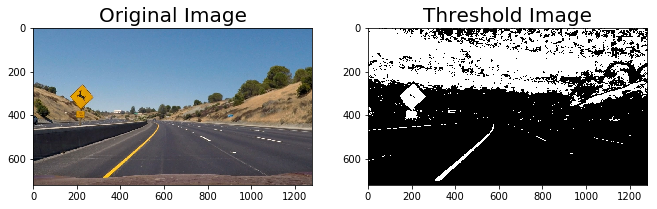

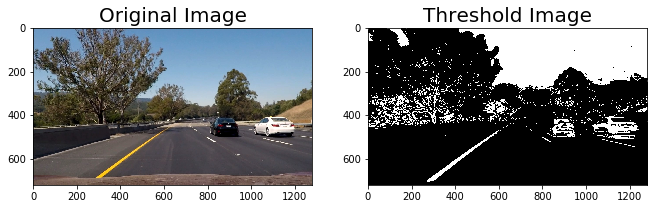

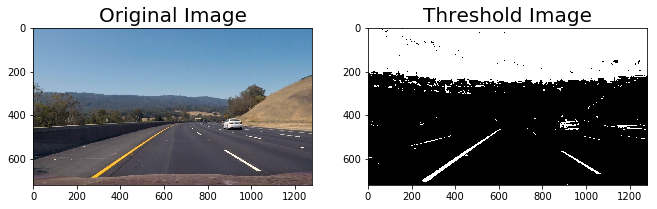

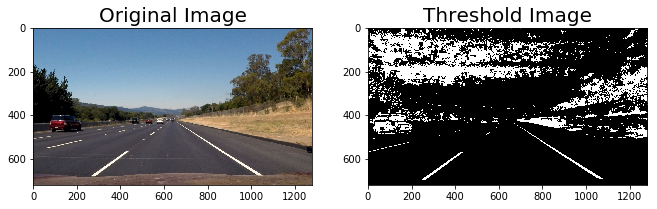

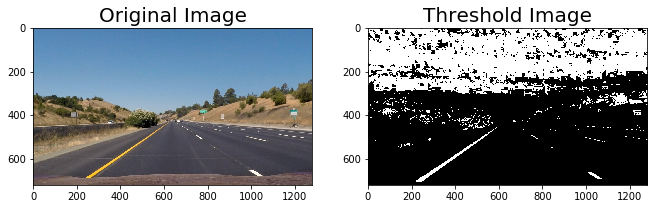

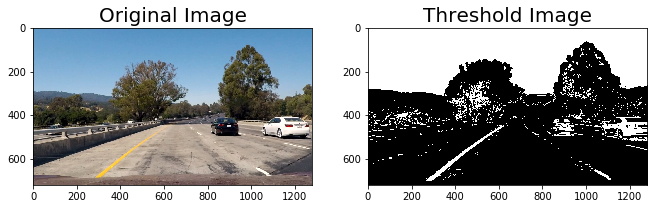

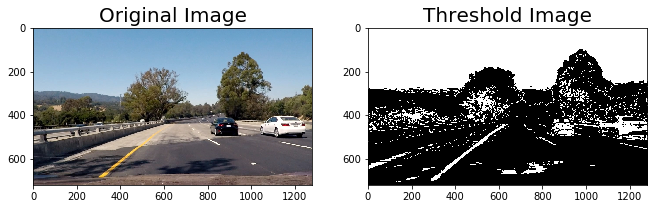

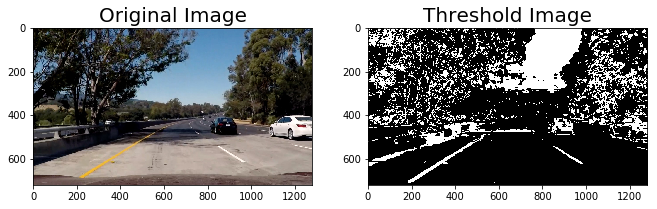

In [8]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

for img in images:
    undist = undistort_image(img)    
    threshold = create_binary_threashold_image(undist)

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,8))
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)

    ax2.imshow(threshold, cmap='gray')
    ax2.set_title('Threshold Image', fontsize=20)

# Find pixes of lane

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        pixels_in_hor_slice = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        
        good_left_inds = (pixels_in_hor_slice & \
                         (nonzerox >= win_xleft_low) & \
                         (nonzerox < win_xleft_high)).nonzero()[0]
                         
        good_right_inds = (pixels_in_hor_slice & \
                         (nonzerox >= win_xright_low) & \
                         (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    global left_fit, right_fit
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

## Print detected lanes

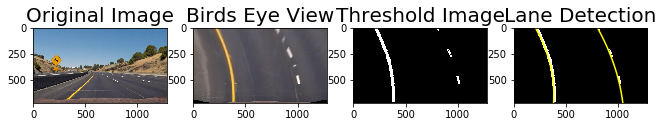

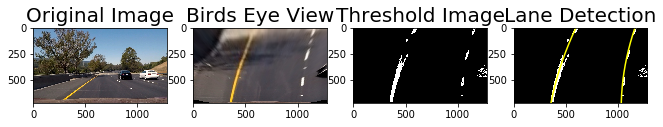

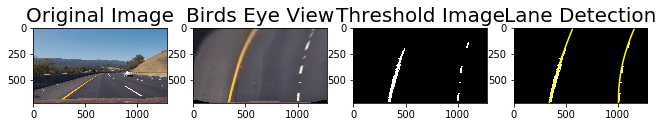

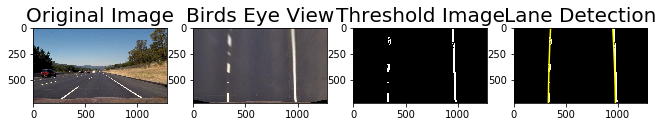

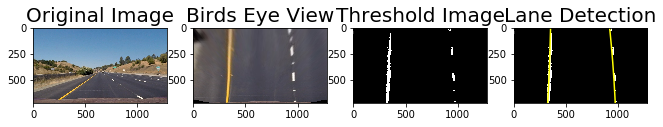

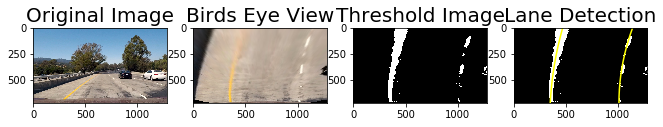

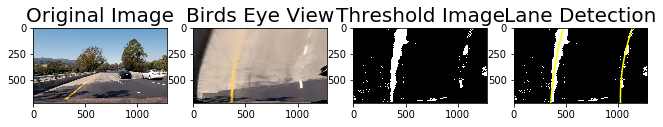

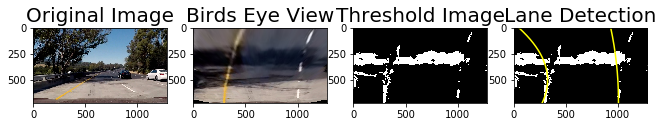

In [11]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

for img in images:
    undist = undistort_image(img)
    birds_eye = transform_to_birds_eye_view(undist)
    threshold = create_binary_threashold_image(birds_eye)
    leftx, lefty, rightx, righty = find_lane_pixels(threshold)
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11,8))
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    
    ax2.imshow(cv2.cvtColor(birds_eye, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birds Eye View', fontsize=20)
    
    ax3.imshow(threshold, cmap='gray')
    ax3.set_title('Threshold Image', fontsize=20)
      
    ax4.plot(left_fitx, ploty, color='yellow')
    ax4.plot(right_fitx, ploty, color='yellow')
    ax4.imshow(threshold, cmap='gray')
    ax4.set_title('Lane Detection', fontsize=20)

# Warp lane back to undistored image

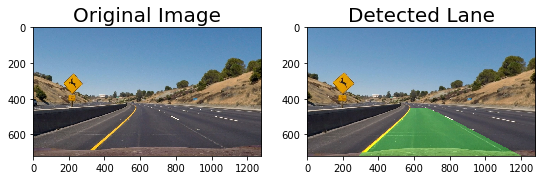

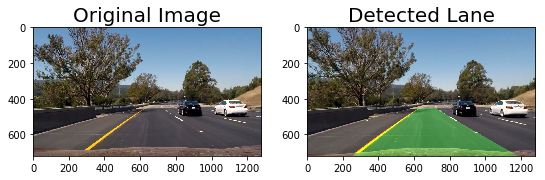

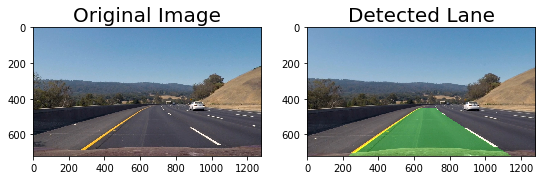

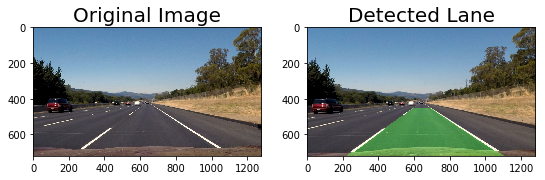

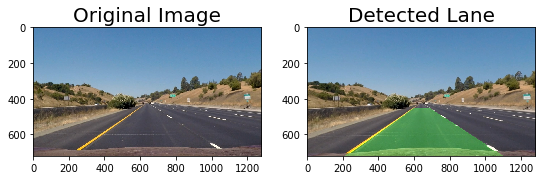

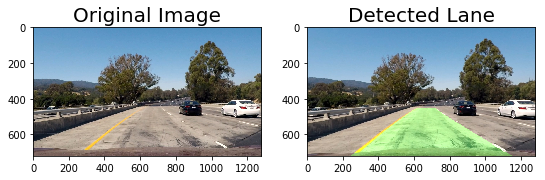

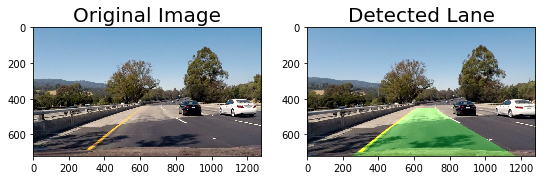

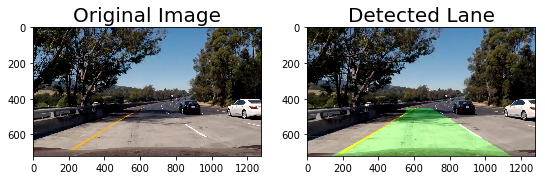

In [12]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))
for img in images:
    undist = undistort_image(img)
    birds_eye = transform_to_birds_eye_view(undist)
    threshold = create_binary_threashold_image(birds_eye)
    leftx, lefty, rightx, righty = find_lane_pixels(threshold)
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    height, width = threshold.shape
    src_points = np.array([[
        ((width/2)-50, (height/2)+90), # Top Left
        ((width/2)+50, (height/2)+90), # Top Right
        (200, height),                 # Bottom Left
        (width-200, height),           # Bottom Right

    ]], dtype=np.float32)

    dst_points = np.array([[
        ((width/4), 0),        # Top Left
        ((width/4)*3, 0),      # Top Right
        ((width/4), height),   # Bottom Left
        ((width/4)*3, height), # Bottom Right
    ]], dtype=np.float32)

    Minv = cv2.getPerspectiveTransform(dst_points, src_points)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(threshold).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
       
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    
    ax2.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    ax2.set_title('Detected Lane', fontsize=20)
    

# Sliding window

In [13]:
def find_lane_pixels_sliding(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        
        pixels_in_hor_slice = (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)
        
        good_left_inds = (pixels_in_hor_slice & \
                         (nonzerox >= win_xleft_low) & \
                         (nonzerox < win_xleft_high)).nonzero()[0]
                         
        good_right_inds = (pixels_in_hor_slice & \
                         (nonzerox >= win_xright_low) & \
                         (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial_sliding(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels_sliding(binary_warped)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

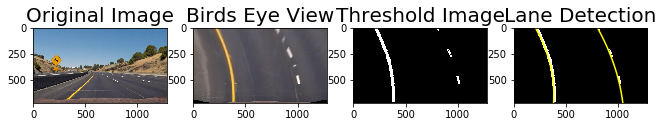

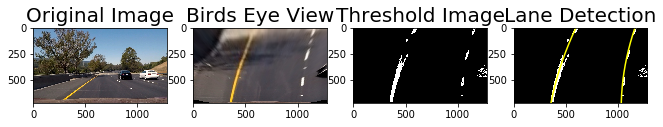

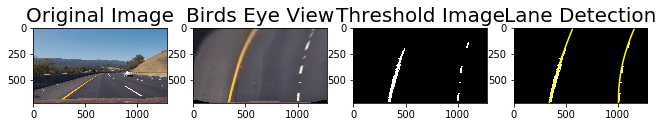

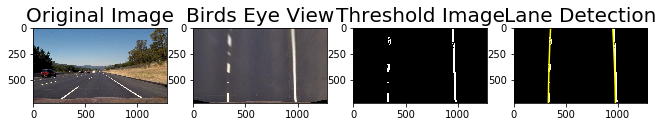

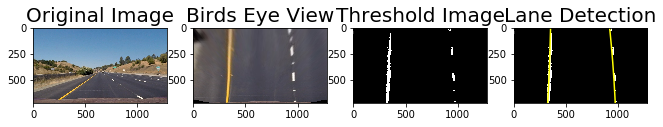

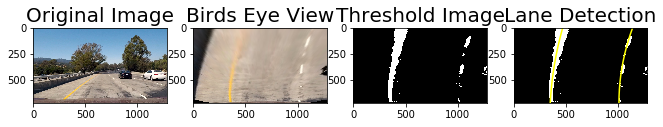

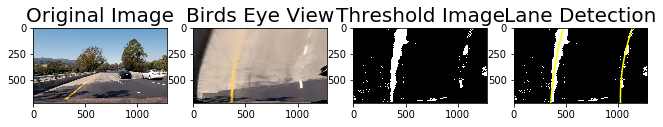

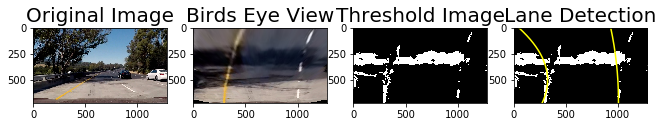

In [14]:
images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

for img in images:
    undist = undistort_image(img)
    birds_eye = transform_to_birds_eye_view(undist)
    threshold = create_binary_threashold_image(birds_eye)
    left_fitx, right_fitx, ploty = fit_polynomial_sliding(threshold)
    
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11,8))
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    
    ax2.imshow(cv2.cvtColor(birds_eye, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birds Eye View', fontsize=20)
    
    ax3.imshow(threshold, cmap='gray')
    ax3.set_title('Threshold Image', fontsize=20)
    
    
    ax4.plot(left_fitx, ploty, color='yellow')
    ax4.plot(right_fitx, ploty, color='yellow')
    ax4.imshow(threshold, cmap='gray')
    ax4.set_title('Lane Detection', fontsize=20)

# Search around poly

Once we process the first image we can bootstrap the process of searching around the already found lanes in the previous image.

In [15]:
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###

    def fit_in_left_line(point):
        x, y = point
        line_position = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
        return ((line_position - margin) < x and x < (line_position + margin))

    def fit_in_right_line(point):
        x, y = point
        line_position = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
        return ((line_position - margin) < x and x < (line_position + margin))

    left_lane_inds = (np.array(list(map(fit_in_left_line, zip(nonzerox, nonzeroy))))).nonzero()[0]
    right_lane_inds = (np.array(list(map(fit_in_right_line, zip(nonzerox, nonzeroy))))).nonzero()[0]

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    return left_fitx, right_fitx, ploty

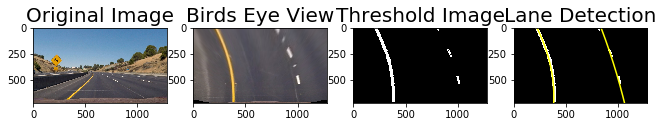

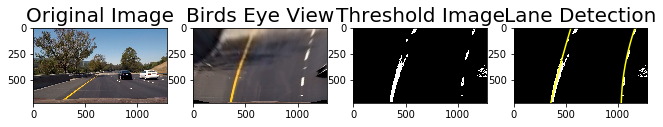

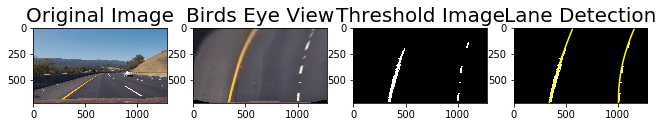

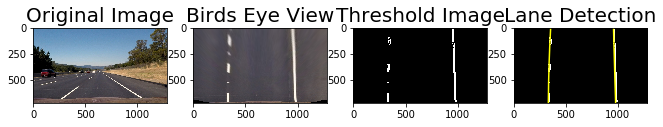

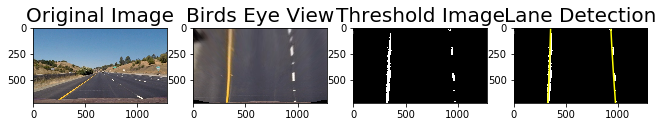

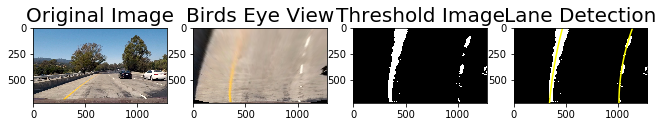

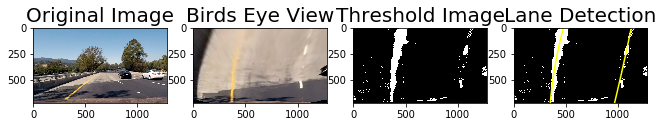

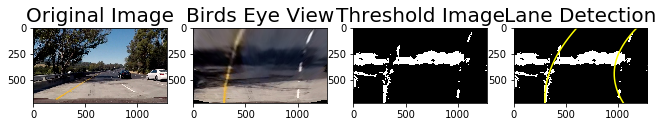

In [16]:
# For the purposes of testing on the test images, we are going to fake the previous fit lanes
left_fit_example = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit_example = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

images = list(map(cv2.imread, glob.glob('test_images/*.jpg')))

for img in images:
    undist = undistort_image(img)
    birds_eye = transform_to_birds_eye_view(undist)
    threshold = create_binary_threashold_image(birds_eye)
    left_fitx, right_fitx, ploty = search_around_poly(threshold, left_fit_example, right_fit_example)
    
    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11,8))
    
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=20)
    
    ax2.imshow(cv2.cvtColor(birds_eye, cv2.COLOR_BGR2RGB))
    ax2.set_title('Birds Eye View', fontsize=20)
    
    ax3.imshow(threshold, cmap='gray')
    ax3.set_title('Threshold Image', fontsize=20)
    
    
    ax4.plot(left_fitx, ploty, color='yellow')
    ax4.plot(right_fitx, ploty, color='yellow')
    ax4.imshow(threshold, cmap='gray')
    ax4.set_title('Lane Detection', fontsize=20)
    

# Final image process

In [17]:
def measure_curvature(ploty, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [18]:
def measure_vehicle_position(width, height, left_fit_cr, right_fit_cr):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    center = width/2
    
    position_of_left_lane = left_fit_cr[0] * height**2 + left_fit_cr[1] * height + left_fit_cr[2]
    position_of_right_lane = right_fit_cr[0] * height**2 + right_fit_cr[1] * height + right_fit_cr[2]
    
    vehicle_position_in_pixels = position_of_left_lane+(position_of_right_lane-position_of_left_lane)/2
    
    vehicle_left_of_center_in_pixels = vehicle_position_in_pixels-center
    
    return vehicle_left_of_center_in_pixels * xm_per_pix

In [19]:
# We need to bootstrap the lane detection, so here are some lanes to start
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def process_image(img):
    undist = undistort_image(img)
    birds_eye = transform_to_birds_eye_view(undist)
    threshold = create_binary_threashold_image(birds_eye)
    
    left_fitx, right_fitx, ploty = search_around_poly(threshold, left_fit, right_fit)
     
    height, width = threshold.shape

    left_curverad, right_curverad = measure_curvature(ploty, left_fit, right_fit)
    
    left_of_center = measure_vehicle_position(width, height, left_fit, right_fit)
    
    src_points = np.array([[
        ((width/2)-50, (height/2)+90), # Top Left
        ((width/2)+50, (height/2)+90), # Top Right
        (200, height),                 # Bottom Left
        (width-200, height),           # Bottom Right

    ]], dtype=np.float32)

    dst_points = np.array([[
        ((width/4), 0),        # Top Left
        ((width/4)*3, 0),      # Top Right
        ((width/4), height),   # Bottom Left
        ((width/4)*3, height), # Bottom Right
    ]], dtype=np.float32)

    Minv = cv2.getPerspectiveTransform(dst_points, src_points)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(threshold).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    
    average_curve = (left_curverad + right_curverad) / 2
    
    # Draw curvature on image
    cv2.putText(
        result, #numpy array on which text is written
        f"Radius of Curvature = {int(average_curve)} m", #text
        (10,50), #position at which writing has to start
        cv2.FONT_HERSHEY_SIMPLEX, #font family
        1, #font size
        (209, 80, 0, 255), #font color
        3) #font stroke
    
    cv2.putText(
        result, #numpy array on which text is written
        f"Vehicle is left {left_of_center}m of center", #text
        (10,100), #position at which writing has to start
        cv2.FONT_HERSHEY_SIMPLEX, #font family
        1, #font size
        (209, 80, 0, 255), #font color
        3) #font stroke   
    
    return result
    

In [22]:
project_video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [08:02<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 51s, sys: 3.17 s, total: 5min 54s
Wall time: 8min 5s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))